In [1]:
%matplotlib widget

import numpy as np
import math
import tensorflow as tf
import tensorflow_probability as tfp

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from jacques import kcqe

# If in dark mode, uncomment the following line
plt.style.use('ggplot')

In [2]:
# Data generation adapted from https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
# Fix random state for reproducibility
np.random.seed(19680801)

np.random.rand(5)

def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

n = 500

#Create random predictors x0 and x1
x0 = randrange(n, -2. * np.pi, 2. * np.pi)
x1 = randrange(n, -2. * np.pi, 2. * np.pi)

#Create response variable y
y = 10. * np.cos(x0) + 0.5 * x1**2 + np.random.normal(loc=0., scale=5., size=n)

In [3]:
#Combine x0 and x1 into a single data array of predictors
x = np.concatenate([x0[:, np.newaxis], x1[:, np.newaxis]], axis=1)

grid_size = 120

#Creates a grid of x values for test set
x_test = np.concatenate(
    [np.tile(np.linspace(-2. * np.pi, 2. * np.pi, num = grid_size), grid_size)[:, np.newaxis],
        np.repeat(np.linspace(-2. * np.pi, 2. * np.pi, num = grid_size), grid_size)[:, np.newaxis]],
    axis=1
)

In [4]:

# x_train_val
x = np.reshape(x, (1, 500, 2))
# y_train_val
y = np.reshape(y, (1, 500))

x_test = np.reshape(x_test, (1, 14400, 2))

x = tf.constant(x, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)
x_test = tf.constant(x_test, dtype=tf.float32)
    
block_size = 50
num_blocks = math.floor(y.shape[1]/block_size)

In [5]:
kcqe_obj = kcqe.KCQE(p=2)
generator = kcqe_obj.generator(x, y, batch_size = 10, block_size = block_size)

In [6]:
x_val, x_train, y_val, y_train = next(generator)
print(x_val.shape)
print(y_val.shape)
print(x_train.shape)
print(y_train.shape)

(10, 50, 2)
(10, 50)
(10, 350, 2)
(10, 350)


In [7]:
# plug in generator instead of raw data to get away from calculating 7-day avg
# initialize parameters at some bad values; otherwise, convergence is instantaneous
param_vec = kcqe_obj.fit(xval_batch_gen = generator,
    num_blocks = num_blocks, 
    tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32),
    optim_method="adam", 
    num_epochs=10, 
    learning_rate=0.1,
    init_param_vec=tf.constant(np.array([3.0, 3.0, 1.0]), dtype=tf.float32),
    verbose = True)

epoch idx = 0
batch idx = 0
loss idx = 1
param estimates vec = 
[2.9000022 2.9000025 1.0999573]
loss = 
2.0158503
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.19520672,  0.16581362, -0.00752452], dtype=float32)>]
epoch idx = 0
batch idx = 1
loss idx = 1loss idx = 1
param estimates vec = 
[2.8016071 2.8001297 1.1997237]
loss = 
1.969323
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.14867027,  0.15928945, -0.00708476], dtype=float32)>]
epoch idx = 0
batch idx = 2
loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[2.7034774 2.700032  1.2995428]
loss = 
1.939555
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.1480176 ,  0.1728633 , -0.00725216], dtype=float32)>]
epoch idx = 0
batch idx = 3
loss idx = 1loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[2.6055884 2.5996752 1.3978994]
loss = 
1.9189894
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.14323984,  0.18157105, -0.00563686], dtype=float32)>

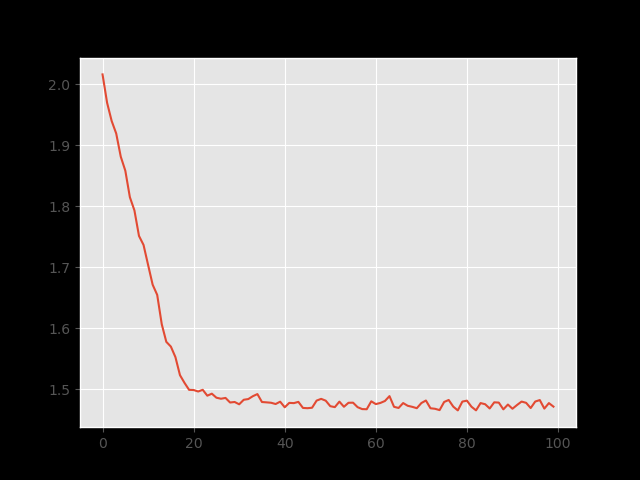

In [8]:
plt.plot(np.arange(len(kcqe_obj.loss_trace)), kcqe_obj.loss_trace)
plt.show()

In [9]:
q_hat = kcqe_obj.predict(param_vec,
                         x_train=x,
                         y_train=y,
                         x_test=x_test,
                         tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32))

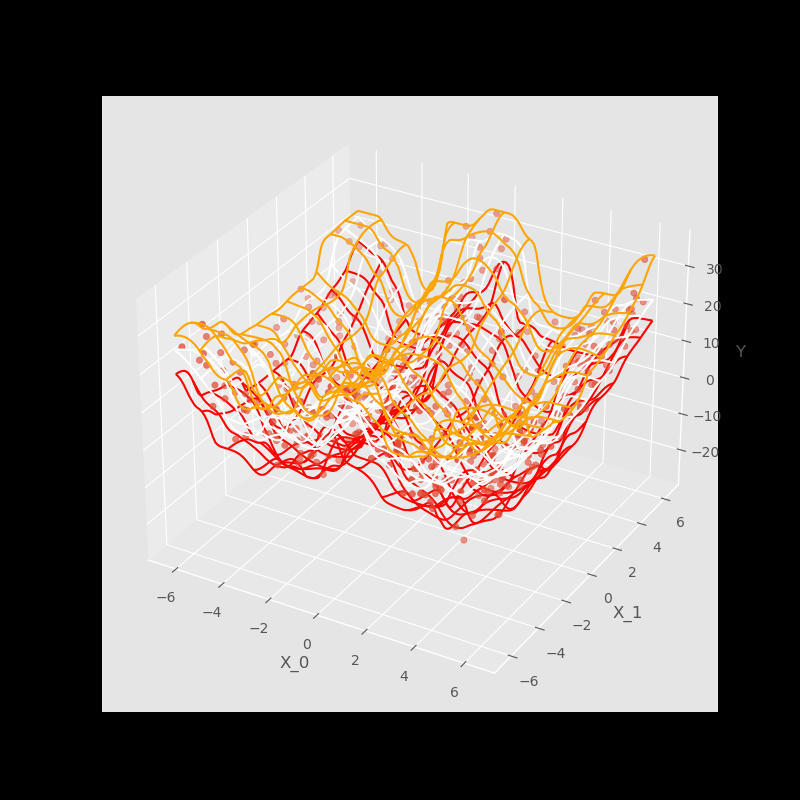

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

ax.scatter(x0, x1, y)

x0_grid = x_test[..., 0].numpy().reshape((grid_size, grid_size))
x1_grid = x_test[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q10 = q_hat[..., 0].numpy().reshape((grid_size, grid_size))
q_grid_median = q_hat[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q90 = q_hat[..., 2].numpy().reshape((grid_size, grid_size))

ax.plot_wireframe(x0_grid, x1_grid, q_grid_q10, rstride=10, cstride=10, color="red")
ax.plot_wireframe(x0_grid, x1_grid, q_grid_median, rstride=10, cstride=10)
ax.plot_wireframe(x0_grid, x1_grid, q_grid_q90, rstride=10, cstride=10, color="orange")

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

plt.show()

In [11]:
kcqe_obj = kcqe.KCQE(x_kernel='gaussian_full', p=2)
generator = kcqe_obj.generator(x, y, batch_size = 10, block_size = block_size)

In [12]:
# plug in generator instead of raw data to get away from calculating 7-day avg
# initialize parameters at some bad values; otherwise, convergence is instantaneous
param_vec = kcqe_obj.fit(xval_batch_gen = generator,
    num_blocks = num_blocks, 
    tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32),
    optim_method="adam", 
    num_epochs=10, 
    learning_rate=0.1,
    verbose = True)

epoch idx = 0
batch idx = 0
loss idx = 1
param estimates vec = 
[0.09999836 0.09999255 0.09998559 0.0996914 ]
loss = 
1.6496117
grads = 
[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.3268622 , -0.04657491, -0.02301593, -0.00102377], dtype=float32)>]
epoch idx = 0
batch idx = 1
loss idx = 1loss idx = 1
param estimates vec = 
[0.19958235 0.19290978 0.09209681 0.19876976]
loss = 
1.618566
grads = 
[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.29405862, -0.02282589,  0.02425893, -0.00149529], dtype=float32)>]
epoch idx = 0
batch idx = 2
loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[0.29787326 0.27609634 0.0748361  0.29832014]
loss = 
1.5766178
grads = 
[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.24331681, -0.01061869,  0.00598314, -0.00134932], dtype=float32)>]
epoch idx = 0
batch idx = 3
loss idx = 1loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[0.3947741  0.3423178  0.06008251 0.3912188 ]
loss = 
1.5536143
grads = 
[<tf.Tensor:

In [13]:
q_hat = kcqe_obj.predict(param_vec,
                         x_train=x,
                         y_train=y,
                         x_test=x_test,
                         tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32))

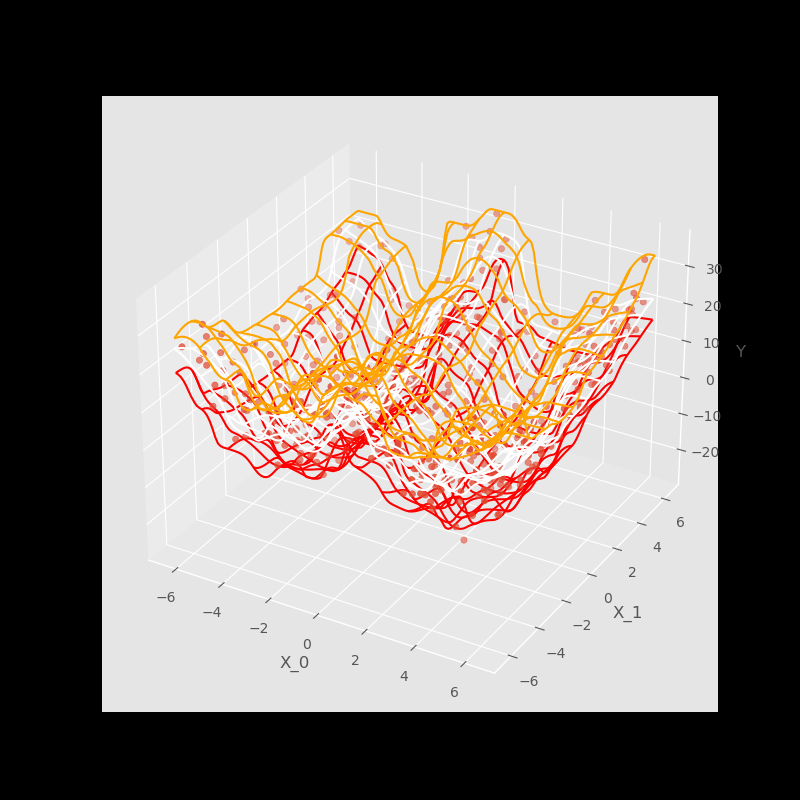

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

ax.scatter(x0, x1, y)

x0_grid = x_test[..., 0].numpy().reshape((grid_size, grid_size))
x1_grid = x_test[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q10 = q_hat[..., 0].numpy().reshape((grid_size, grid_size))
q_grid_median = q_hat[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q90 = q_hat[..., 2].numpy().reshape((grid_size, grid_size))

ax.plot_wireframe(x0_grid, x1_grid, q_grid_q10, rstride=10, cstride=10, color="red")
ax.plot_wireframe(x0_grid, x1_grid, q_grid_median, rstride=10, cstride=10)
ax.plot_wireframe(x0_grid, x1_grid, q_grid_q90, rstride=10, cstride=10, color="orange")

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

plt.show()